# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part1 MNIST data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a digit(MNIST data) given its label. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
The MNIST datasets will be downloaded into the 'data' directory. If you want to change the directory the data is saved in, change mnist_data_dir with where you want. <br>

In [1]:
from download import *
import os
from utils import load_mnist
mnist_data_dir = './data'
prepare_data_dir(mnist_data_dir)
download_mnist(mnist_data_dir)
data_array , data_y = load_mnist(os.path.join(mnist_data_dir,'mnist'))
print(data_array.shape)
print(data_y.shape)

Found MNIST - skip
(70000, 28, 28, 1)
(70000, 10)


## <a name="1"></a> 1. Building a network

In this section, you will implement neural networks for (1) generative model to draw a digit (2) discriminative model to distinguish real image from generated image. You can use some function in *ops.py* or you can make it as you want. Just write the code in whatever way you find most clear.

In [2]:
from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

It is time for a generative model. It takes batch size, sample size(the dimension of latent variable or so called *noise*), y_dim(the dimension of label), the output size(should be 28 here) and z,y (Tensorflow Variables for latent variable and label respectively). It should return the image 28x28 output of which each element is in [0,1]. Note that you should define Tensorflow Variables within the variable scope.

You should utilize the label variable y in your model. The simplest way is concatenate the label variable and features or raw image.

In [3]:
def gern_net(batch_size, z , y , sample_size, y_dim, output_size):
    with tf.variable_scope('gen'):
        #### TODO ####
        z = tf.concat([z, y], 1)
        
        w1 = tf.get_variable('w1', [z.shape[1], 1024], tf.float32, initializer = tf.random_normal_initializer(stddev=0.02))
        b1 = tf.get_variable('b1', [1024], initializer = tf.constant_initializer(0.0))
        net = tf.nn.relu(batch_normal(fully_connect(z, w1, b1), scope='gern_bn1'))
        
        w2 = tf.get_variable('w2', [net.shape[1], 128*7*7], tf.float32, initializer = tf.random_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', [128*7*7], initializer = tf.constant_initializer(0.0))
        net = tf.nn.relu(batch_normal(fully_connect(net, w2, b2), scope='gern_bn2'))
        net = tf.reshape(net, [batch_size, 7, 7, 128])
        
        w3 = tf.get_variable('w3', [5, 5, 64, net.shape[-1]], initializer=tf.random_normal_initializer(stddev=0.02))
        b3 = tf.get_variable('b3', [64], initializer=tf.constant_initializer(0.0))
        net = de_conv(net, w3, b3, out_shape=[batch_size, 14, 14, 64])
        net = tf.nn.relu(batch_normal(net, scope='gern_bn3'))
        
        w4 = tf.get_variable('w4', [5, 5, 1, net.shape[-1]], initializer=tf.random_normal_initializer(stddev=0.02))
        b4 = tf.get_variable('b4', [1], initializer=tf.constant_initializer(0.0))
        net = de_conv(net, w4, b4, out_shape=[batch_size, 28, 28, 1])
        
        return tf.nn.sigmoid(net)
    ####TODO ####

Now, it's time for a discriminative model. It takes image data and label variable y. It should return the value for which the model is certain that the image is real and its logit. (i.e return the value in [0,1] and its logit). Note that you should define Tensorflow Variables within the variable scope again.

You may use the label variable or not. Here, again concatenating is the simplest way to utilize it.

In [4]:
def dis_net(image_data , y, reuse=False):
    with tf.variable_scope('dis',reuse=reuse):
        #### TODO ####
        #x = tf.reshape(image_data, [128, 28*28])
        #image_y = tf.concat([x, y], 1)
        #image_y = image_y + tf.random_normal(shape=tf.shape(image_y), mean=0.0, stddev=0.2, dtype=tf.float32)
        
        _, y_dim = y.get_shape()
        batch_size = 128
        y = tf.reshape(y, [batch_size, 1, 1, y_dim])
        x = conv_cond_concat(image_data, y)
        x = x + tf.random_normal(shape=tf.shape(x), mean=0.0, stddev=0.02, dtype=tf.float32)
        
        w1 = tf.get_variable('w1', [5, 5, x.shape[-1], 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable('b1', [64], initializer=tf.constant_initializer(0.0))
        net = lrelu(conv2d(x, w1, b1))
        
        w2 = tf.get_variable('w2', [5, 5, net.shape[-1], 128], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', [128], initializer=tf.constant_initializer(0.0))
        net = lrelu(batch_normal(conv2d(net, w2, b2), scope='dis_bn1'))
        net = tf.reshape(net, [batch_size, -1])
        
        w3 = tf.get_variable('w3', [net.shape[1], 1024], tf.float32, initializer = tf.random_normal_initializer(stddev=0.02))
        b3 = tf.get_variable('b3', [1024], initializer = tf.constant_initializer(0.0))
        net = lrelu(batch_normal(fully_connect(net, w3, b3), 'dis_bn2'))
        
        w4 = tf.get_variable('w4', [net.shape[1], 1], tf.float32, initializer = tf.random_normal_initializer(stddev=0.02))
        b4 = tf.get_variable('b4', [1], initializer = tf.constant_initializer(0.0))
        out_logit = fully_connect(net, w4, b4)
        out = tf.nn.sigmoid(out_logit)
        
        return out, out_logit
    #### TODO ####

## <a name="2"></a> 2. Build a main part and train

In this section, you will implement the main part. You should define the loss function for each model(TODO part). Then run the code and check the model draws a digit for given label.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

Also, you can change all other hyperparameters such as learning rate, batch size. But be sure to define **batch size bigger than 100**.

In [5]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

learning_rate = 0.0002
batch_size = 128
EPOCH = 2
loss_step    = 50
display_step = 50
sample_size = 100
y_dim = 10
channel = 1
output_size = 28
sample_dir = 'samples_for_test'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define the loss function in the TODO part. Modify only loss part.

Discriminator loss : log[D(x)] + log[1-D(G(z))]
Generator loss     : log[D(G(z)]

If you write the code correctly and run the code, it will display 10x10 images(each row shows one of the number). 

Also, it will save the generated images in the 'sample_dir' directory. So if you want to see it, check that directory.

**Please be sure that you ran the above codes**.

EPOCH 0 step 50: D: loss = 0.8025874 G: loss=1.1769758 
EPOCH 0 step 100: D: loss = 0.8463492 G: loss=1.0937541 
EPOCH 0 step 150: D: loss = 1.0836596 G: loss=0.7926348 
EPOCH 0 step 200: D: loss = 1.0679121 G: loss=0.9883898 
EPOCH 0 step 250: D: loss = 1.0613279 G: loss=1.1270602 
EPOCH 0 step 300: D: loss = 1.1096060 G: loss=0.9459590 
EPOCH 0 step 350: D: loss = 1.4002615 G: loss=0.9429044 
EPOCH 0 step 400: D: loss = 1.2686764 G: loss=0.9288028 
EPOCH 0 step 450: D: loss = 1.2427323 G: loss=0.7633351 
EPOCH 0 step 500: D: loss = 1.2628870 G: loss=0.6712571 


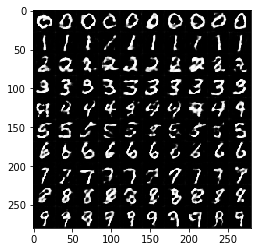

EPOCH 1 step 550: D: loss = 1.2490464 G: loss=0.6798036 
EPOCH 1 step 600: D: loss = 1.3480504 G: loss=0.8270893 
EPOCH 1 step 650: D: loss = 1.2950501 G: loss=0.6600196 
EPOCH 1 step 700: D: loss = 1.2922604 G: loss=0.7187580 
EPOCH 1 step 750: D: loss = 1.3283359 G: loss=0.6862247 
EPOCH 1 step 800: D: loss = 1.2781466 G: loss=0.7519335 
EPOCH 1 step 850: D: loss = 1.3079104 G: loss=0.7014089 
EPOCH 1 step 900: D: loss = 1.3349782 G: loss=0.7130699 
EPOCH 1 step 950: D: loss = 1.3155361 G: loss=0.7367315 
EPOCH 1 step 1000: D: loss = 1.3443947 G: loss=0.7282348 
EPOCH 1 step 1050: D: loss = 1.3133444 G: loss=0.6949531 


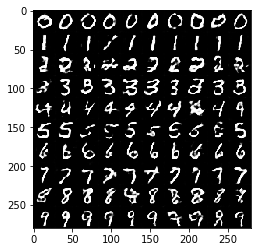

EPOCH 2 step 1100: D: loss = 1.3089521 G: loss=0.7075593 
EPOCH 2 step 1150: D: loss = 1.3354300 G: loss=0.7231973 
EPOCH 2 step 1200: D: loss = 1.3422160 G: loss=0.6949676 
EPOCH 2 step 1250: D: loss = 1.3210409 G: loss=0.6954588 
EPOCH 2 step 1300: D: loss = 1.3220179 G: loss=0.7210529 
EPOCH 2 step 1350: D: loss = 1.3552477 G: loss=0.6952831 
EPOCH 2 step 1400: D: loss = 1.3156426 G: loss=0.7080218 
EPOCH 2 step 1450: D: loss = 1.3246104 G: loss=0.7303671 
EPOCH 2 step 1500: D: loss = 1.3253787 G: loss=0.7191167 
EPOCH 2 step 1550: D: loss = 1.3176409 G: loss=0.7405156 
EPOCH 2 step 1600: D: loss = 1.3206629 G: loss=0.7162651 


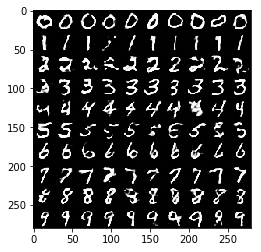

In [6]:
sample_z = np.random.uniform(-1 , 1 , size = [batch_size , sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro, D_logits = dis_net(images, y, False)

G_pro, G_logits = dis_net(fake_images, y, True)

#### TODO ####
# DEFINE LOSS FUNCTION #

D_fake_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(G_pro), logits=G_logits))

D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_pro), logits=D_logits))
G_fake_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(G_pro), logits=G_logits))

D_loss = D_real_loss + D_fake_loss
G_loss = G_fake_loss

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(data_array) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(data_array , data_y , batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:

                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

            if np.mod(step , display_step) == 1:

                sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:sample_label(batch_size)})
                sample_images = sample_images[:100,:,:,:]
                image_name = './{}/train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
                save_images(sample_images , [10,10] , image_name)

        img = mpimg.imread(image_name)
        imgplot = plt.imshow(img)
        plt.show()

        e = e + 1
        batch_num = 0
